# Sunspots Forecasting

In [1]:
%load_ext autoreload
%autoreload 2

## Install `tfutils`

In [3]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [175]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import losses, callbacks, optimizers, layers
from tfutils.timeseries import windowed_dataset, plot_series
from tfutils.visualize import plot_learning_curve
import matplotlib.pyplot as plt

## Sunspots Data

In [21]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-07-25 17:30:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-07-25 17:30:40 (103 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [22]:
df = pd.read_csv('/tmp/sunspots.csv').iloc[:, 1:]
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [134]:
time = pd.to_datetime(df['Date'])
series = df['Monthly Mean Total Sunspot Number'].to_numpy()

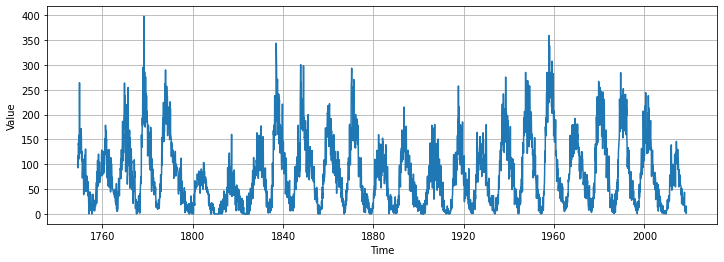

In [28]:
plt.figure(figsize=(12, 4))
plot_series(time, series)

## Train Test Split

In [135]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_test = time[split_time:]
x_test = series[split_time:]

## Make a Windowed Dataset

In [138]:
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
test_dataset = windowed_dataset(x_test, WINDOW_SIZE, BATCH_SIZE, None)

## Create Models

In [38]:
TFMODELS = {}
PREDICTIONS = {}

## Model 1 : `dense-3layer`

### Create the model

In [35]:
model_name = 'dense-3layer'

In [39]:
model = tf.keras.models.Sequential([
    layers.Dense(20, input_shape=(WINDOW_SIZE,), activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
], name=model_name)

model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=1e-7, momentum=0.9))
model.summary()

Model: "dense-3layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [40]:
history = model.fit(train_dataset, epochs=100, verbose=0)
TFMODELS[model_name] = model

### Learning Curve

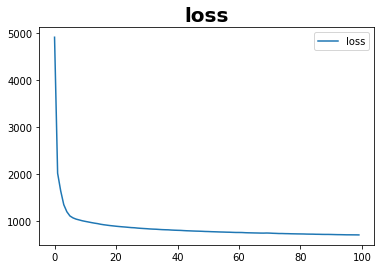

In [50]:
plot_learning_curve(history.history);

### Predict

In [41]:
PREDICTIONS[model_name] = model.predict(test_dataset)

### Evaluate

In [44]:
tf.keras.metrics.mean_squared_error(x_test[WINDOW_SIZE:], tf.squeeze(PREDICTIONS[model_name])).numpy()

331.52817

## Model 2: `conv1d-stacked-lstm`

In [180]:
from tfutils.timeseries import windowed_dataset

In [205]:
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = windowed_dataset(x_train.reshape(-1, 1), WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
test_dataset = windowed_dataset(x_test.reshape(-1, 1), WINDOW_SIZE, BATCH_SIZE, None)

### Create the model

In [206]:
model_name = 'conv1d-stacked-lstm'

In [207]:
model = tf.keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=5, strides=1,
                  padding='causal', activation='relu', input_shape=[None, 1]),
    layers.LSTM(units=64, return_sequences=True),
    layers.LSTM(units=64),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1),
    layers.Lambda(lambda x: x*400)
], name=model_name)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(loss=tf.losses.Huber(), optimizer=optimizers.SGD(learning_rate=1e-8, momentum=0.9), metrics=['mae'])
model.summary()

Model: "conv1d-stacked-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)         

### Fit the model

In [208]:
history = model.fit(train_dataset, epochs=100, verbose=0, callbacks=[lr_scheduler])

### Learning Rate vs Loss

In [209]:
history_df = pd.DataFrame(history.history).dropna()
history_df = history_df.loc[~np.isinf(history_df['loss'])].reset_index(drop=True)
history_df

,loss,mae,lr
0,340.503540,341.003540,1.000000e-08
1,323.792542,324.292542,1.122018e-08
2,305.189301,305.689301,1.258925e-08
3,288.098633,288.598633,1.412538e-08
4,271.988617,272.488617,1.584893e-08
...,...,...,...
95,52.295174,52.793438,5.623413e-04
96,39.097198,39.593643,6.309574e-04
97,40.708687,41.204891,7.079458e-04
98,54.010841,54.509121,7.943282e-04


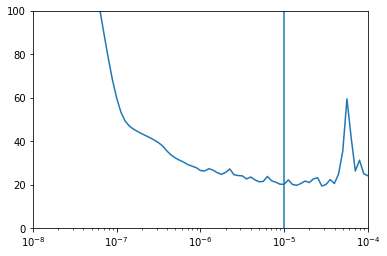

In [210]:
plt.semilogx(history_df['lr'], history_df['loss']);
plt.axis([1e-8, 1e-4, 0, 100])
plt.axvline(1e-5);

### recompile and fit model

In [211]:
model.compile(loss=tf.losses.Huber(), optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=['mae'])
history = model.fit(train_dataset, epochs=500, verbose=0)

### Learning Curve

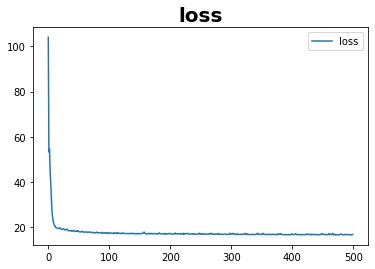

In [212]:
plot_learning_curve(history.history);

### Predict

In [213]:
PREDICTIONS[model_name] = model.predict(test_dataset)

### Evaluate

In [214]:
PREDICTIONS[model_name].shape

(171, 1)

In [200]:
x_test[WINDOW_SIZE:].shape

(171,)

In [215]:
tf.keras.metrics.mean_squared_error(x_test[WINDOW_SIZE:], tf.squeeze(PREDICTIONS[model_name])).numpy()

219.86563

## Performance Comparison

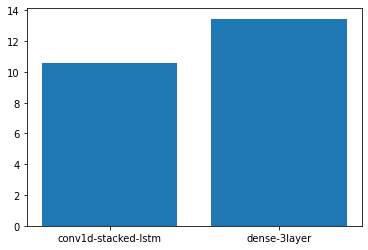

In [218]:
scores = {model_name: tf.keras.metrics.mean_absolute_error(x_test[WINDOW_SIZE:], tf.squeeze(pred)) for model_name, pred in PREDICTIONS.items()}
scores = dict(sorted(scores.items(), key = lambda k: k[1]))
plt.bar(scores.keys(), scores.values());